In [1]:

# # Task 2: Apply Perturbations to ALS Genes and Generate Embeddings
# 
# **Objective**: Create perturbations in disease-specific genes and embed with GeneFormer V2
# 
# **Workflow**:
# 1. Load data and identify ALS vs PN (healthy) cells
# 2. Apply perturbations (knock-down/up) to ALS genes
# 3. Generate GeneFormer embeddings for baseline and all perturbations
# 4. **Generate condition-specific baselines** (ALS and PN separately)
# 5. Save all embeddings for downstream analysis

# ## Setup

In [2]:


import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml

# ============================================
# PATH HANDLING
# ============================================
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR

import sys
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import utilities
from utils.perturbation import GenePerturbationWorkflow
from utils.embeddings import GeneFormerEmbedder
from utils.data_io import DataIOManager
from utils.smoke_tests import SmokeTestRunner

print(f"Project root: {PROJECT_ROOT}")
print("Setup complete")

Project root: /Users/lubainakothari/Desktop/perturbation_newstructure
Setup complete


In [3]:


# ============================================
# LOAD CONFIGURATION
# ============================================
config_path = PROJECT_ROOT / "config" / "config.yaml"

if not config_path.exists():
    raise FileNotFoundError(f"Config not found: {config_path}")

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print(f"Config loaded from: {config_path}")

# Extract settings
SMOKE_TEST = config['smoke_test']['enabled']
RANDOM_SEED = config['random_seed']
ALS_GENES = config['als_genes']
kd_factors = config['perturbation']['knock_down']['factors']
ku_factors = config['perturbation']['knock_up']['factors'] 

# Define paths
DATA_PATH = PROJECT_ROOT / config['data']['raw_data_path']
CACHE_DIR = PROJECT_ROOT / config['data']['cache_dir']
RESULTS_DIR = PROJECT_ROOT / config['data']['results_dir']

TASK2_DIR = RESULTS_DIR / "task2"
TABLES_DIR = TASK2_DIR / "tables"
FIGURES_DIR = TASK2_DIR / "figures"

# Create directories
for dir_path in [CACHE_DIR, TASK2_DIR, TABLES_DIR, FIGURES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

# Configure plotting
sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=config['visualization']['figure_dpi'], facecolor='white')
sns.set_style("whitegrid")

print(f"\nConfiguration:")
print(f"  Smoke test: {SMOKE_TEST}")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  ALS genes: {len(ALS_GENES)}")
print(f"  Output: {TASK2_DIR}")


# ## 1. Load Data and Identify Cell Populations

Config loaded from: /Users/lubainakothari/Desktop/perturbation_newstructure/config/config.yaml

Configuration:
  Smoke test: True
  Random seed: 0
  ALS genes: 5
  Output: /Users/lubainakothari/Desktop/perturbation_newstructure/results/task2


In [4]:


print("\n" + "=" * 70)
print("DATA LOADING")
print("=" * 70)

if SMOKE_TEST:
    print(f"\nSMOKE TEST MODE: {config['smoke_test']['n_cells']} cells × {config['smoke_test']['n_genes']} genes")
    
    runner = SmokeTestRunner(str(DATA_PATH))
    adata = runner.create_smoke_test_subset(
        n_cells=config['smoke_test']['n_cells'],
        n_genes=config['smoke_test']['n_genes'],
        save_path=str(CACHE_DIR / "smoke_test_subset.h5ad")
    )
else:
    print("\nFULL PIPELINE MODE")
    
    io_manager = DataIOManager(base_dir=str(PROJECT_ROOT / "data"), cache_dir=str(CACHE_DIR))
    adata = io_manager.load_adata_efficient(str(DATA_PATH), backed=False)

    # Stratified sampling to keep proportions
    from sklearn.model_selection import train_test_split

    n_sample = 500  # Adjust based on your RAM
    if adata.n_obs > n_sample:
        # Sample while maintaining condition balance
        indices = []
        for condition in adata.obs['Condition'].unique():
            cond_idx = np.where(adata.obs['Condition'] == condition)[0]
            n_take = int(n_sample * len(cond_idx) / adata.n_obs)
            sampled = np.random.choice(cond_idx, n_take, replace=False)
            indices.extend(sampled)
        
        adata = adata[indices, :].copy()
        
print(f"\nData loaded:")
print(f"  Cells: {adata.n_obs:,}")
print(f"  Genes: {adata.n_vars:,}")

# Identify cell populations by condition
if 'Condition' not in adata.obs.columns:
    raise ValueError("'Condition' column not found - cannot identify ALS/PN cells")

als_mask = adata.obs['Condition'] == 'ALS'
pn_mask = adata.obs['Condition'] == 'PN'

print(f"\nCell populations:")
print(f"  ALS (diseased): {als_mask.sum():,} cells")
print(f"  PN (healthy): {pn_mask.sum():,} cells")


# ## 2. Select Target Genes


DATA LOADING

SMOKE TEST MODE: 200 cells × 100 genes

Data loaded:
  Cells: 50
  Genes: 100

Cell populations:
  ALS (diseased): 32 cells
  PN (healthy): 18 cells


In [5]:


print("\n" + "=" * 70)
print("GENE SELECTION")
print("=" * 70)

# Find available ALS genes
available_als_genes = []
for gene in ALS_GENES:
    if gene in adata.var_names:
        available_als_genes.append(gene)
        if len(available_als_genes) == 3:
            break

if SMOKE_TEST:
    # Smoke test: Use ALS genes if found, otherwise fallback to first 3 genes
    if len(available_als_genes) > 0:
        target_genes = available_als_genes
        print(f"\nSmoke test: Found {len(target_genes)} ALS gene(s)")
        print(f"  Using: {target_genes}")
    else:
        target_genes = list(adata.var_names[:3])
        print("\nSmoke test: No ALS genes found, using first 3 genes as fallback")
        print(f"  Using: {target_genes}")
else:
    # Full pipeline: ALS genes are REQUIRED
    if len(available_als_genes) == 0:
        raise ValueError(
            f"No ALS genes found in dataset.\n"
            f"Required: {ALS_GENES}\n"
            f"Available in data: {list(adata.var_names[:10])}..."
        )
    
    target_genes = available_als_genes
    print(f"\nFull pipeline: Found {len(target_genes)} ALS gene(s)")
    print(f"  Using: {target_genes}")
    
    # Show remaining ALS genes if any
    remaining_als = [g for g in ALS_GENES if g not in target_genes and g in adata.var_names]
    if remaining_als:
        print(f"  Note: {len(remaining_als)} additional ALS gene(s) available but not tested: {remaining_als}")

print(f"\nTarget genes selected: {target_genes}")



# ## 3. Generate Perturbations
# 
# Create perturbations in both diseased (ALS) and healthy (PN) cells:
# - **ALS perturbations**: Test therapeutic potential
# - **PN perturbations**: Assess safety profile


GENE SELECTION

Smoke test: No ALS genes found, using first 3 genes as fallback
  Using: ['MAP1B', 'KHDRBS2', 'DMD']

Target genes selected: ['MAP1B', 'KHDRBS2', 'DMD']


In [6]:


print("\n" + "=" * 70)
print("PERTURBATION GENERATION")
print("=" * 70)

# Initialize workflow
workflow = GenePerturbationWorkflow(adata, copy=True)

# Get perturbation parameters from config
kd_factors = config['perturbation']['knock_down']['factors']
ku_factors = config['perturbation']['knock_up']['factors']
ku_noise = config['perturbation']['knock_up']['noise_level']
ku_min_expr = config['perturbation']['knock_up']['min_expr']

print(f"\nPerturbation settings:")
print(f"  Genes: {len(target_genes)}")
print(f"  Knock-down factors: {kd_factors}")
print(f"  Knock-up factors: {ku_factors}")

# Track metadata for all perturbations
metadata_list = []


PERTURBATION GENERATION
✓ GenePerturbationWorkflow initialized
  Cells: 50
  Genes: 100

Perturbation settings:
  Genes: 3
  Knock-down factors: [0.2, 0.5]
  Knock-up factors: [2.0, 3.0]


In [7]:


# ============================================
# KNOCK-DOWN in ALS cells
# ============================================
print("\n1. Knock-down in ALS cells (diseased)")
print("-" * 50)

for gene in target_genes:
    for factor in kd_factors:
        pert_id = f'KD_{gene}_{factor:.1f}_ALS'
        
        try:
            workflow.knock_down(
                genes=gene,
                reduction_factor=factor,
                cell_subset=als_mask,
                perturbation_id=pert_id,
                seed=RANDOM_SEED
            )
            
            metadata_list.append({
                'perturbation_id': pert_id,
                'gene': gene,
                'type': 'knock_down',
                'factor': factor,
                'condition': 'ALS',
                'n_cells': als_mask.sum()
            })
            print(f"  {pert_id}")
        except Exception as e:
            print(f"  ERROR - {pert_id}: {e}")


1. Knock-down in ALS cells (diseased)
--------------------------------------------------
✓ Knock-down: 1 gene(s), 32 cells
  Reduction: 80% (log2FC = -2.32)
  KD_MAP1B_0.2_ALS
✓ Knock-down: 1 gene(s), 32 cells
  Reduction: 50% (log2FC = -1.00)
  KD_MAP1B_0.5_ALS
✓ Knock-down: 1 gene(s), 32 cells
  Reduction: 80% (log2FC = -2.32)
  KD_KHDRBS2_0.2_ALS
✓ Knock-down: 1 gene(s), 32 cells
  Reduction: 50% (log2FC = -1.00)
  KD_KHDRBS2_0.5_ALS
✓ Knock-down: 1 gene(s), 32 cells
  Reduction: 80% (log2FC = -2.32)
  KD_DMD_0.2_ALS
✓ Knock-down: 1 gene(s), 32 cells
  Reduction: 50% (log2FC = -1.00)
  KD_DMD_0.5_ALS


In [8]:


# ============================================
# KNOCK-UP in ALS cells
# ============================================
print("\n2. Knock-up in ALS cells (diseased)")
print("-" * 50)

for gene in target_genes:
    for factor in ku_factors:
        pert_id = f'KU_{gene}_{factor:.1f}_ALS'
        
        try:
            workflow.knock_up(
                genes=gene,
                amplification_factor=factor,
                cell_subset=als_mask,
                noise_level=ku_noise,
                min_expr=ku_min_expr,
                perturbation_id=pert_id,
                seed=RANDOM_SEED
            )
            
            metadata_list.append({
                'perturbation_id': pert_id,
                'gene': gene,
                'type': 'knock_up',
                'factor': factor,
                'condition': 'ALS',
                'n_cells': als_mask.sum()
            })
            print(f"  {pert_id}")
        except Exception as e:
            print(f"  ERROR - {pert_id}: {e}")


2. Knock-up in ALS cells (diseased)
--------------------------------------------------
✓ Knock-up: 1 gene(s), 32 cells
  Amplification: 2.0x (log2FC = 1.00)
  KU_MAP1B_2.0_ALS
✓ Knock-up: 1 gene(s), 32 cells
  Amplification: 3.0x (log2FC = 1.58)
  KU_MAP1B_3.0_ALS
✓ Knock-up: 1 gene(s), 32 cells
  Amplification: 2.0x (log2FC = 1.00)
  KU_KHDRBS2_2.0_ALS
✓ Knock-up: 1 gene(s), 32 cells
  Amplification: 3.0x (log2FC = 1.58)
  KU_KHDRBS2_3.0_ALS
✓ Knock-up: 1 gene(s), 32 cells
  Amplification: 2.0x (log2FC = 1.00)
  KU_DMD_2.0_ALS
✓ Knock-up: 1 gene(s), 32 cells
  Amplification: 3.0x (log2FC = 1.58)
  KU_DMD_3.0_ALS


In [9]:


# ============================================
# CONTROL PERTURBATIONS in PN cells
# ============================================
print("\n3. Control perturbations in PN cells (healthy)")
print("-" * 50)
print("Matching ALS perturbations for safety assessment")

for gene in target_genes:
    # Knock-downs in PN
    for factor in kd_factors:
        pert_id = f'KD_{gene}_{factor:.1f}_PN'
        try:
            workflow.knock_down(
                genes=gene,
                reduction_factor=factor,
                cell_subset=pn_mask,
                perturbation_id=pert_id,
                seed=RANDOM_SEED
            )
            metadata_list.append({
                'perturbation_id': pert_id,
                'gene': gene,
                'type': 'knock_down',
                'factor': factor,
                'condition': 'PN',
                'n_cells': pn_mask.sum()
            })
            print(f"  {pert_id}")
        except Exception as e:
            print(f"  ERROR - {pert_id}: {e}")
    
    # Knock-ups in PN
    for factor in ku_factors:
        pert_id = f'KU_{gene}_{factor:.1f}_PN'
        try:
            workflow.knock_up(
                genes=gene,
                amplification_factor=factor,
                cell_subset=pn_mask,
                noise_level=ku_noise,
                min_expr=ku_min_expr,
                perturbation_id=pert_id,
                seed=RANDOM_SEED
            )
            metadata_list.append({
                'perturbation_id': pert_id,
                'gene': gene,
                'type': 'knock_up',
                'factor': factor,
                'condition': 'PN',
                'n_cells': pn_mask.sum()
            })
            print(f"  {pert_id}")
        except Exception as e:
            print(f"  ERROR - {pert_id}: {e}")


3. Control perturbations in PN cells (healthy)
--------------------------------------------------
Matching ALS perturbations for safety assessment
✓ Knock-down: 1 gene(s), 18 cells
  Reduction: 80% (log2FC = -2.32)
  KD_MAP1B_0.2_PN
✓ Knock-down: 1 gene(s), 18 cells
  Reduction: 50% (log2FC = -1.00)
  KD_MAP1B_0.5_PN
✓ Knock-up: 1 gene(s), 18 cells
  Amplification: 2.0x (log2FC = 1.00)
  KU_MAP1B_2.0_PN
✓ Knock-up: 1 gene(s), 18 cells
  Amplification: 3.0x (log2FC = 1.58)
  KU_MAP1B_3.0_PN
✓ Knock-down: 1 gene(s), 18 cells
  Reduction: 80% (log2FC = -2.32)
  KD_KHDRBS2_0.2_PN
✓ Knock-down: 1 gene(s), 18 cells
  Reduction: 50% (log2FC = -1.00)
  KD_KHDRBS2_0.5_PN
✓ Knock-up: 1 gene(s), 18 cells
  Amplification: 2.0x (log2FC = 1.00)
  KU_KHDRBS2_2.0_PN
✓ Knock-up: 1 gene(s), 18 cells
  Amplification: 3.0x (log2FC = 1.58)
  KU_KHDRBS2_3.0_PN
✓ Knock-down: 1 gene(s), 18 cells
  Reduction: 80% (log2FC = -2.32)
  KD_DMD_0.2_PN
✓ Knock-down: 1 gene(s), 18 cells
  Reduction: 50% (log2FC = -1.

In [10]:


# ============================================
# PERTURBATION SUMMARY
# ============================================
print("\n" + "=" * 70)
print("PERTURBATION SUMMARY")
print("=" * 70)

metadata_df = pd.DataFrame(metadata_list)

print(f"\nTotal perturbations: {len(metadata_df)}")
print(f"\nBy type:")
print(metadata_df['type'].value_counts())
print(f"\nBy condition:")
print(metadata_df['condition'].value_counts())
print(f"\nBy gene:")
print(metadata_df['gene'].value_counts().head(10))

# Save metadata
metadata_path = TABLES_DIR / "perturbation_metadata.csv"
metadata_df.to_csv(metadata_path, index=False)
print(f"\nMetadata saved: {metadata_path}")


# ## 4. Setup GeneFormer Model
# 
# Download and configure the GeneFormer V2 model (gf-12L-95M-i4096)


PERTURBATION SUMMARY

Total perturbations: 24

By type:
type
knock_down    12
knock_up      12
Name: count, dtype: int64

By condition:
condition
ALS    12
PN     12
Name: count, dtype: int64

By gene:
gene
MAP1B      8
KHDRBS2    8
DMD        8
Name: count, dtype: int64

Metadata saved: /Users/lubainakothari/Desktop/perturbation_newstructure/results/task2/tables/perturbation_metadata.csv


In [11]:


print("\n" + "=" * 70)
print("GENEFORMER MODEL SETUP")
print("=" * 70)

import os
from huggingface_hub import snapshot_download
from transformers import AutoConfig

# Model path
model_path_full = "./geneformer_cache/models--ctheodoris--Geneformer/snapshots/628247599bf5f5aa2de011b9fd982e137059ef52/gf-12L-95M-i4096"

if os.path.exists(model_path_full):
    print(f"\nModel already cached: {model_path_full}")
else:
    print("\nDownloading gf-12L-95M-i4096 from HuggingFace PR #418...")
    print("  Size: ~152MB (first time only)")
    
    model_path = snapshot_download(
        repo_id="ctheodoris/Geneformer",
        revision="refs/pr/418",
        allow_patterns="gf-12L-95M-i4096/*",
        cache_dir="./geneformer_cache"
    )
    
    model_path_full = os.path.join(model_path, "gf-12L-95M-i4096")
    print(f"\nModel downloaded: {model_path_full}")

# Verify model
print("\nVerifying model architecture...")
model_config = AutoConfig.from_pretrained(model_path_full)

print(f"Model verified:")
print(f"  Architecture: gf-12L-95M-i4096")
print(f"  Layers: {model_config.num_hidden_layers}")
print(f"  Hidden size: {model_config.hidden_size}")
print(f"  Vocabulary: {model_config.vocab_size:,} genes")

# Update config
config['geneformer']['model_name'] = model_path_full
print(f"\nConfig updated to use: {model_path_full}")


# ## 5. Patch GeneFormer for CPU
# 
# GeneFormer requires GPU by default. Patch it to run on CPU.


GENEFORMER MODEL SETUP

Model already cached: ./geneformer_cache/models--ctheodoris--Geneformer/snapshots/628247599bf5f5aa2de011b9fd982e137059ef52/gf-12L-95M-i4096

Verifying model architecture...
Model verified:
  Architecture: gf-12L-95M-i4096
  Layers: 12
  Hidden size: 512
  Vocabulary: 20,275 genes

Config updated to use: ./geneformer_cache/models--ctheodoris--Geneformer/snapshots/628247599bf5f5aa2de011b9fd982e137059ef52/gf-12L-95M-i4096


In [12]:


print("\n" + "=" * 70)
print("PATCHING GENEFORMER FOR CPU")
print("=" * 70)

import torch

if not torch.cuda.is_available():
    print("\nNo GPU detected - applying CPU patches...")
    
    # Patch 1: Intercept .to("cuda") calls
    original_to = torch.Tensor.to
    def patched_to(self, *args, **kwargs):
        args = tuple("cpu" if arg == "cuda" else arg for arg in args)
        if 'device' in kwargs and kwargs['device'] == "cuda":
            kwargs['device'] = "cpu"
        return original_to(self, *args, **kwargs)
    torch.Tensor.to = patched_to
    
    # Patch 2: Intercept torch.tensor device parameter
    original_tensor = torch.tensor
    def patched_tensor(*args, **kwargs):
        if 'device' in kwargs:
            if kwargs['device'] == "cuda" or str(kwargs['device']).startswith("cuda"):
                kwargs['device'] = "cpu"
        return original_tensor(*args, **kwargs)
    torch.tensor = patched_tensor
    
    # Patch 3: Override CUDA availability
    torch.cuda.is_available = lambda: False
    
    # Patch 4: Set default device
    try:
        torch.set_default_device("cpu")
    except:
        pass
    
    print("Applied CPU patches:")
    print("  - Tensor.to() calls")
    print("  - torch.tensor() device parameter")
    print("  - torch.cuda.is_available() → False")
    print("  - Default device → CPU")
    print("\nNote: CPU processing will be slower than GPU")
else:
    print("\nGPU detected - no patching needed")


# ## 6. Initialize GeneFormer Embedder


PATCHING GENEFORMER FOR CPU

No GPU detected - applying CPU patches...
Applied CPU patches:
  - Tensor.to() calls
  - torch.tensor() device parameter
  - torch.cuda.is_available() → False
  - Default device → CPU

Note: CPU processing will be slower than GPU


In [13]:


print("\n" + "=" * 70)
print("INITIALIZING GENEFORMER V2")
print("=" * 70)

# Initialize IO manager for caching
io_manager = DataIOManager(base_dir=str(PROJECT_ROOT / "data"), cache_dir=str(CACHE_DIR))

# Initialize GeneFormer embedder
embedder = GeneFormerEmbedder(
    model_name=config['geneformer']['model_name'],
    embedding_dim=config['geneformer']['embedding_dim'],
    emb_layer=config['geneformer']['emb_layer']
)

print(f"\nGeneFormer V2 initialized:")
print(f"  Model: {config['geneformer']['model_name']}")
print(f"  Embedding dim: {config['geneformer']['embedding_dim']}")
print(f"  Batch size: {config['geneformer']['batch_size']}")


# ## 7. Generate Baseline Embeddings
# 
# Generate embeddings for the original, unperturbed dataset


INITIALIZING GENEFORMER V2
DataIOManager initialized
  Data directory: /Users/lubainakothari/Desktop/perturbation_newstructure/data
  Cache directory: /Users/lubainakothari/Desktop/perturbation_newstructure/cache
Initializing GeneFormer V2: ./geneformer_cache/models--ctheodoris--Geneformer/snapshots/628247599bf5f5aa2de011b9fd982e137059ef52/gf-12L-95M-i4096
  Using device: cpu
✓ GeneFormer V2 initialized
  Model: ./geneformer_cache/models--ctheodoris--Geneformer/snapshots/628247599bf5f5aa2de011b9fd982e137059ef52/gf-12L-95M-i4096
  Embedding dim: 256
  ⚠ Running on CPU (GPU not available)

GeneFormer V2 initialized:
  Model: ./geneformer_cache/models--ctheodoris--Geneformer/snapshots/628247599bf5f5aa2de011b9fd982e137059ef52/gf-12L-95M-i4096
  Embedding dim: 256
  Batch size: 50


In [14]:


print("\n" + "=" * 70)
print("BASELINE EMBEDDINGS (ALL CELLS)")
print("=" * 70)

baseline_cache = "task2_baseline_embeddings.npy"

if io_manager.cache_exists(baseline_cache):
    print("Loading cached baseline embeddings...")
    baseline_embeddings = np.load(io_manager.get_cache_path(baseline_cache))
    print(f"Loaded from cache: {baseline_embeddings.shape}")
else:
    print("Generating baseline embeddings with GeneFormer V2...")
    baseline_embeddings = embedder.embed_adata(adata, batch_size=config['geneformer']['batch_size'])
    
    # Cache for future use
    np.save(io_manager.get_cache_path(baseline_cache), baseline_embeddings)
    print(f"Generated and cached: {baseline_embeddings.shape}")


# ## 8. Generate Condition-Specific Baseline Embeddings
# 
# **Critical for disease rescue analysis**: Separate baselines for ALS and PN cells


BASELINE EMBEDDINGS (ALL CELLS)
Loading cached baseline embeddings...
Loaded from cache: (50, 512)


In [15]:


print("\n" + "=" * 70)
print("CONDITION-SPECIFIC BASELINES")
print("=" * 70)

# ============================================
# ALS BASELINE (Diseased State)
# ============================================
adata_als = adata[als_mask].copy()
als_baseline_cache = "task2_als_baseline_embeddings.npy"

if io_manager.cache_exists(als_baseline_cache):
    als_baseline_embeddings = np.load(io_manager.get_cache_path(als_baseline_cache))
    print(f"ALS baseline loaded from cache: {als_baseline_embeddings.shape}")
else:
    print(f"Generating ALS baseline ({als_mask.sum()} cells)...")
    als_baseline_embeddings = embedder.embed_adata(adata_als, batch_size=config['geneformer']['batch_size'])
    np.save(io_manager.get_cache_path(als_baseline_cache), als_baseline_embeddings)
    print(f"ALS baseline generated: {als_baseline_embeddings.shape}")

# ============================================
# PN BASELINE (Healthy State)
# ============================================
adata_pn = adata[pn_mask].copy()
pn_baseline_cache = "task2_pn_baseline_embeddings.npy"

if io_manager.cache_exists(pn_baseline_cache):
    pn_baseline_embeddings = np.load(io_manager.get_cache_path(pn_baseline_cache))
    print(f"PN baseline loaded from cache: {pn_baseline_embeddings.shape}")
else:
    print(f"Generating PN baseline ({pn_mask.sum()} cells)...")
    pn_baseline_embeddings = embedder.embed_adata(adata_pn, batch_size=config['geneformer']['batch_size'])
    np.save(io_manager.get_cache_path(pn_baseline_cache), pn_baseline_embeddings)
    print(f"PN baseline generated: {pn_baseline_embeddings.shape}")

# ============================================
# COMPUTE REFERENCE CENTROIDS
# ============================================
als_centroid = als_baseline_embeddings.mean(axis=0)
pn_centroid = pn_baseline_embeddings.mean(axis=0)
baseline_disease_distance = np.linalg.norm(als_centroid - pn_centroid)

print(f"\nCondition-specific baselines complete:")
print(f"  ALS baseline: {als_baseline_embeddings.shape}")
print(f"  PN baseline: {pn_baseline_embeddings.shape}")
print(f"  ALS ↔ PN distance: {baseline_disease_distance:.3f}")

# Save centroids for Task 3
centroids_dict = {
    'als_centroid': als_centroid,
    'pn_centroid': pn_centroid,
    'baseline_disease_distance': baseline_disease_distance
}
np.savez(io_manager.get_cache_path("task2_reference_centroids.npz"), **centroids_dict)
print(f"\nReference centroids saved for Task 3 analysis")


# ## 9. Generate Perturbation Embeddings


CONDITION-SPECIFIC BASELINES
ALS baseline loaded from cache: (32, 512)
PN baseline loaded from cache: (18, 512)

Condition-specific baselines complete:
  ALS baseline: (32, 512)
  PN baseline: (18, 512)
  ALS ↔ PN distance: 0.102

Reference centroids saved for Task 3 analysis


In [16]:


print("\n" + "=" * 70)
print("PERTURBATION EMBEDDINGS")
print("=" * 70)

perturbation_embeddings = {}

print(f"\nGenerating embeddings for {len(metadata_df)} perturbations...")
print("This may take several minutes...\n")

for i, row in metadata_df.iterrows():
    pert_id = row['perturbation_id']
    cache_name = f"task2_{pert_id}_embeddings.npy"
    
    if io_manager.cache_exists(cache_name):
        # Load from cache
        emb = np.load(io_manager.get_cache_path(cache_name))
        print(f"  [{i+1:3d}/{len(metadata_df)}] {pert_id}: cached")
    else:
        # Generate new embeddings
        adata_pert = workflow.get_perturbation(pert_id)
        emb = embedder.embed_adata(adata_pert, batch_size=config['geneformer']['batch_size'])
        
        # Cache
        np.save(io_manager.get_cache_path(cache_name), emb)
        print(f"  [{i+1:3d}/{len(metadata_df)}] {pert_id}: {emb.shape}")
    
    perturbation_embeddings[pert_id] = emb

print(f"\nAll {len(perturbation_embeddings)} perturbation embeddings generated")


# ## 10. Save All Embeddings


PERTURBATION EMBEDDINGS

Generating embeddings for 24 perturbations...
This may take several minutes...

  [  1/24] KD_MAP1B_0.2_ALS: cached
  [  2/24] KD_MAP1B_0.5_ALS: cached
  [  3/24] KD_KHDRBS2_0.2_ALS: cached
  [  4/24] KD_KHDRBS2_0.5_ALS: cached
  [  5/24] KD_DMD_0.2_ALS: cached
  [  6/24] KD_DMD_0.5_ALS: cached
  [  7/24] KU_MAP1B_2.0_ALS: cached
  [  8/24] KU_MAP1B_3.0_ALS: cached
  [  9/24] KU_KHDRBS2_2.0_ALS: cached
  [ 10/24] KU_KHDRBS2_3.0_ALS: cached
  [ 11/24] KU_DMD_2.0_ALS: cached
  [ 12/24] KU_DMD_3.0_ALS: cached
  [ 13/24] KD_MAP1B_0.2_PN: cached
  [ 14/24] KD_MAP1B_0.5_PN: cached
  [ 15/24] KU_MAP1B_2.0_PN: cached
  [ 16/24] KU_MAP1B_3.0_PN: cached
  [ 17/24] KD_KHDRBS2_0.2_PN: cached
  [ 18/24] KD_KHDRBS2_0.5_PN: cached
  [ 19/24] KU_KHDRBS2_2.0_PN: cached
  [ 20/24] KU_KHDRBS2_3.0_PN: cached
  [ 21/24] KD_DMD_0.2_PN: cached
  [ 22/24] KD_DMD_0.5_PN: cached
  [ 23/24] KU_DMD_2.0_PN: cached
  [ 24/24] KU_DMD_3.0_PN: cached

All 24 perturbation embeddings generated


In [17]:
# ## 9.5. Validate Rank Shifts (GeneFormer Compatibility Check)
# 
# **Critical**: Check if perturbations actually changed gene ranks

# In[NEW]:

print("\n" + "=" * 70)
print("RANK-SHIFT VALIDATION")
print("=" * 70)

print("\nGeneFormer uses rank-value encoding - validating that")
print("perturbations actually shift gene ranks...\n")

from utils.perturbation import PerturbationValidator

validator = PerturbationValidator()

# Test a few perturbations (sample from each type)
test_sample = metadata_df.sample(min(5, len(metadata_df)), random_state=RANDOM_SEED)

rank_validation_results = []

for _, row in test_sample.iterrows():
    pert_id = row['perturbation_id']
    gene = row['gene']
    
    # Get perturbed data
    adata_pert = workflow.get_perturbation(pert_id)
    
    # Validate rank shifts
    rank_metrics = validator.validate_rank_shifts(adata, adata_pert, gene)
    
    rank_validation_results.append(rank_metrics)
    
    status = "✓" if rank_metrics['is_effective_for_geneformer'] else "⚠"
    print(f"{status} {pert_id}")
    print(f"   Mean rank shift: {rank_metrics['mean_abs_rank_shift']:.0f} positions")
    print(f"   Cells changed rank: {rank_metrics['pct_cells_changed_rank']:.1f}%")
    
    if rank_metrics['warning']:
        print(f"   WARNING: {rank_metrics['warning']}")
    print()

# Summary
rank_validation_df = pd.DataFrame(rank_validation_results)
effective_count = rank_validation_df['is_effective_for_geneformer'].sum()

print(f"\nValidation Summary:")
print(f"  Tested: {len(rank_validation_df)} perturbations")
print(f"  Effective for GeneFormer: {effective_count}/{len(rank_validation_df)}")
print(f"  Mean rank shift: {rank_validation_df['mean_abs_rank_shift'].mean():.0f} positions")

if effective_count < len(rank_validation_df):
    print(f"\n⚠ WARNING: Some perturbations may be invisible to GeneFormer")
    print(f"  Consider using stronger factors (10x up, 0.1x down)")
    print(f"  Or switch to percentile-based perturbations")
else:
    print(f"\n✓ All tested perturbations are GeneFormer-compatible")

# Save validation results
rank_validation_df.to_csv(TABLES_DIR / "rank_shift_validation.csv", index=False)

print("\n" + "=" * 70)
print("SAVING EMBEDDINGS")
print("=" * 70)

# Combine all embeddings
embeddings_dict = {
    'baseline': baseline_embeddings,
    'als_baseline': als_baseline_embeddings,
    'pn_baseline': pn_baseline_embeddings,
    **perturbation_embeddings
}

# Save to HDF5
embeddings_file = "task2_all_embeddings.h5"
io_manager.save_embeddings_hdf5(embeddings_dict, filename=embeddings_file)

embeddings_path = CACHE_DIR / embeddings_file
print(f"\nAll embeddings saved: {embeddings_path}")
print(f"  Total embedding sets: {len(embeddings_dict)}")
print(f"  File size: {embeddings_path.stat().st_size / (1024**2):.1f} MB")


# ## 11. Quick Summary Visualization


RANK-SHIFT VALIDATION

GeneFormer uses rank-value encoding - validating that
perturbations actually shift gene ranks...

⚠ KU_DMD_3.0_ALS
   Mean rank shift: 13 positions
   Cells changed rank: 50.0%

⚠ KU_DMD_2.0_ALS
   Mean rank shift: 8 positions
   Cells changed rank: 46.0%

⚠ KU_DMD_2.0_PN
   Mean rank shift: 6 positions
   Cells changed rank: 30.0%

⚠ KU_MAP1B_2.0_PN
   Mean rank shift: 4 positions
   Cells changed rank: 24.0%

⚠ KD_DMD_0.2_PN
   Mean rank shift: 9 positions
   Cells changed rank: 32.0%


Validation Summary:
  Tested: 5 perturbations
  Effective for GeneFormer: 0/5
  Mean rank shift: 8 positions

⚠ WARNING: Some perturbations may be invisible to GeneFormer
  Consider using stronger factors (10x up, 0.1x down)
  Or switch to percentile-based perturbations

SAVING EMBEDDINGS
Saving 27 embedding sets to: /Users/lubainakothari/Desktop/perturbation_newstructure/cache/task2_all_embeddings.h5


Saving: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 195.49it/s]

✓ Saved (4.9 MB)

All embeddings saved: /Users/lubainakothari/Desktop/perturbation_newstructure/cache/task2_all_embeddings.h5
  Total embedding sets: 27
  File size: 4.9 MB


In [18]:


print("\n" + "=" * 70)
print("SAVING EMBEDDINGS")
print("=" * 70)

# Combine all embeddings
embeddings_dict = {
    'baseline': baseline_embeddings,
    'als_baseline': als_baseline_embeddings,
    'pn_baseline': pn_baseline_embeddings,
    **perturbation_embeddings
}

# Save to HDF5
embeddings_file = "task2_all_embeddings.h5"
io_manager.save_embeddings_hdf5(embeddings_dict, filename=embeddings_file)

embeddings_path = CACHE_DIR / embeddings_file
print(f"\nAll embeddings saved: {embeddings_path}")
print(f"  Total embedding sets: {len(embeddings_dict)}")
print(f"  File size: {embeddings_path.stat().st_size / (1024**2):.1f} MB")


# ## 11. Quick Summary Visualization


SAVING EMBEDDINGS
Saving 27 embedding sets to: /Users/lubainakothari/Desktop/perturbation_newstructure/cache/task2_all_embeddings.h5


Saving: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 192.31it/s]

✓ Saved (4.9 MB)

All embeddings saved: /Users/lubainakothari/Desktop/perturbation_newstructure/cache/task2_all_embeddings.h5
  Total embedding sets: 27
  File size: 4.9 MB



QUICK SUMMARY

Computing centroid shifts...
Quick summary saved: /Users/lubainakothari/Desktop/perturbation_newstructure/results/task2/tables/quick_embedding_summary.csv


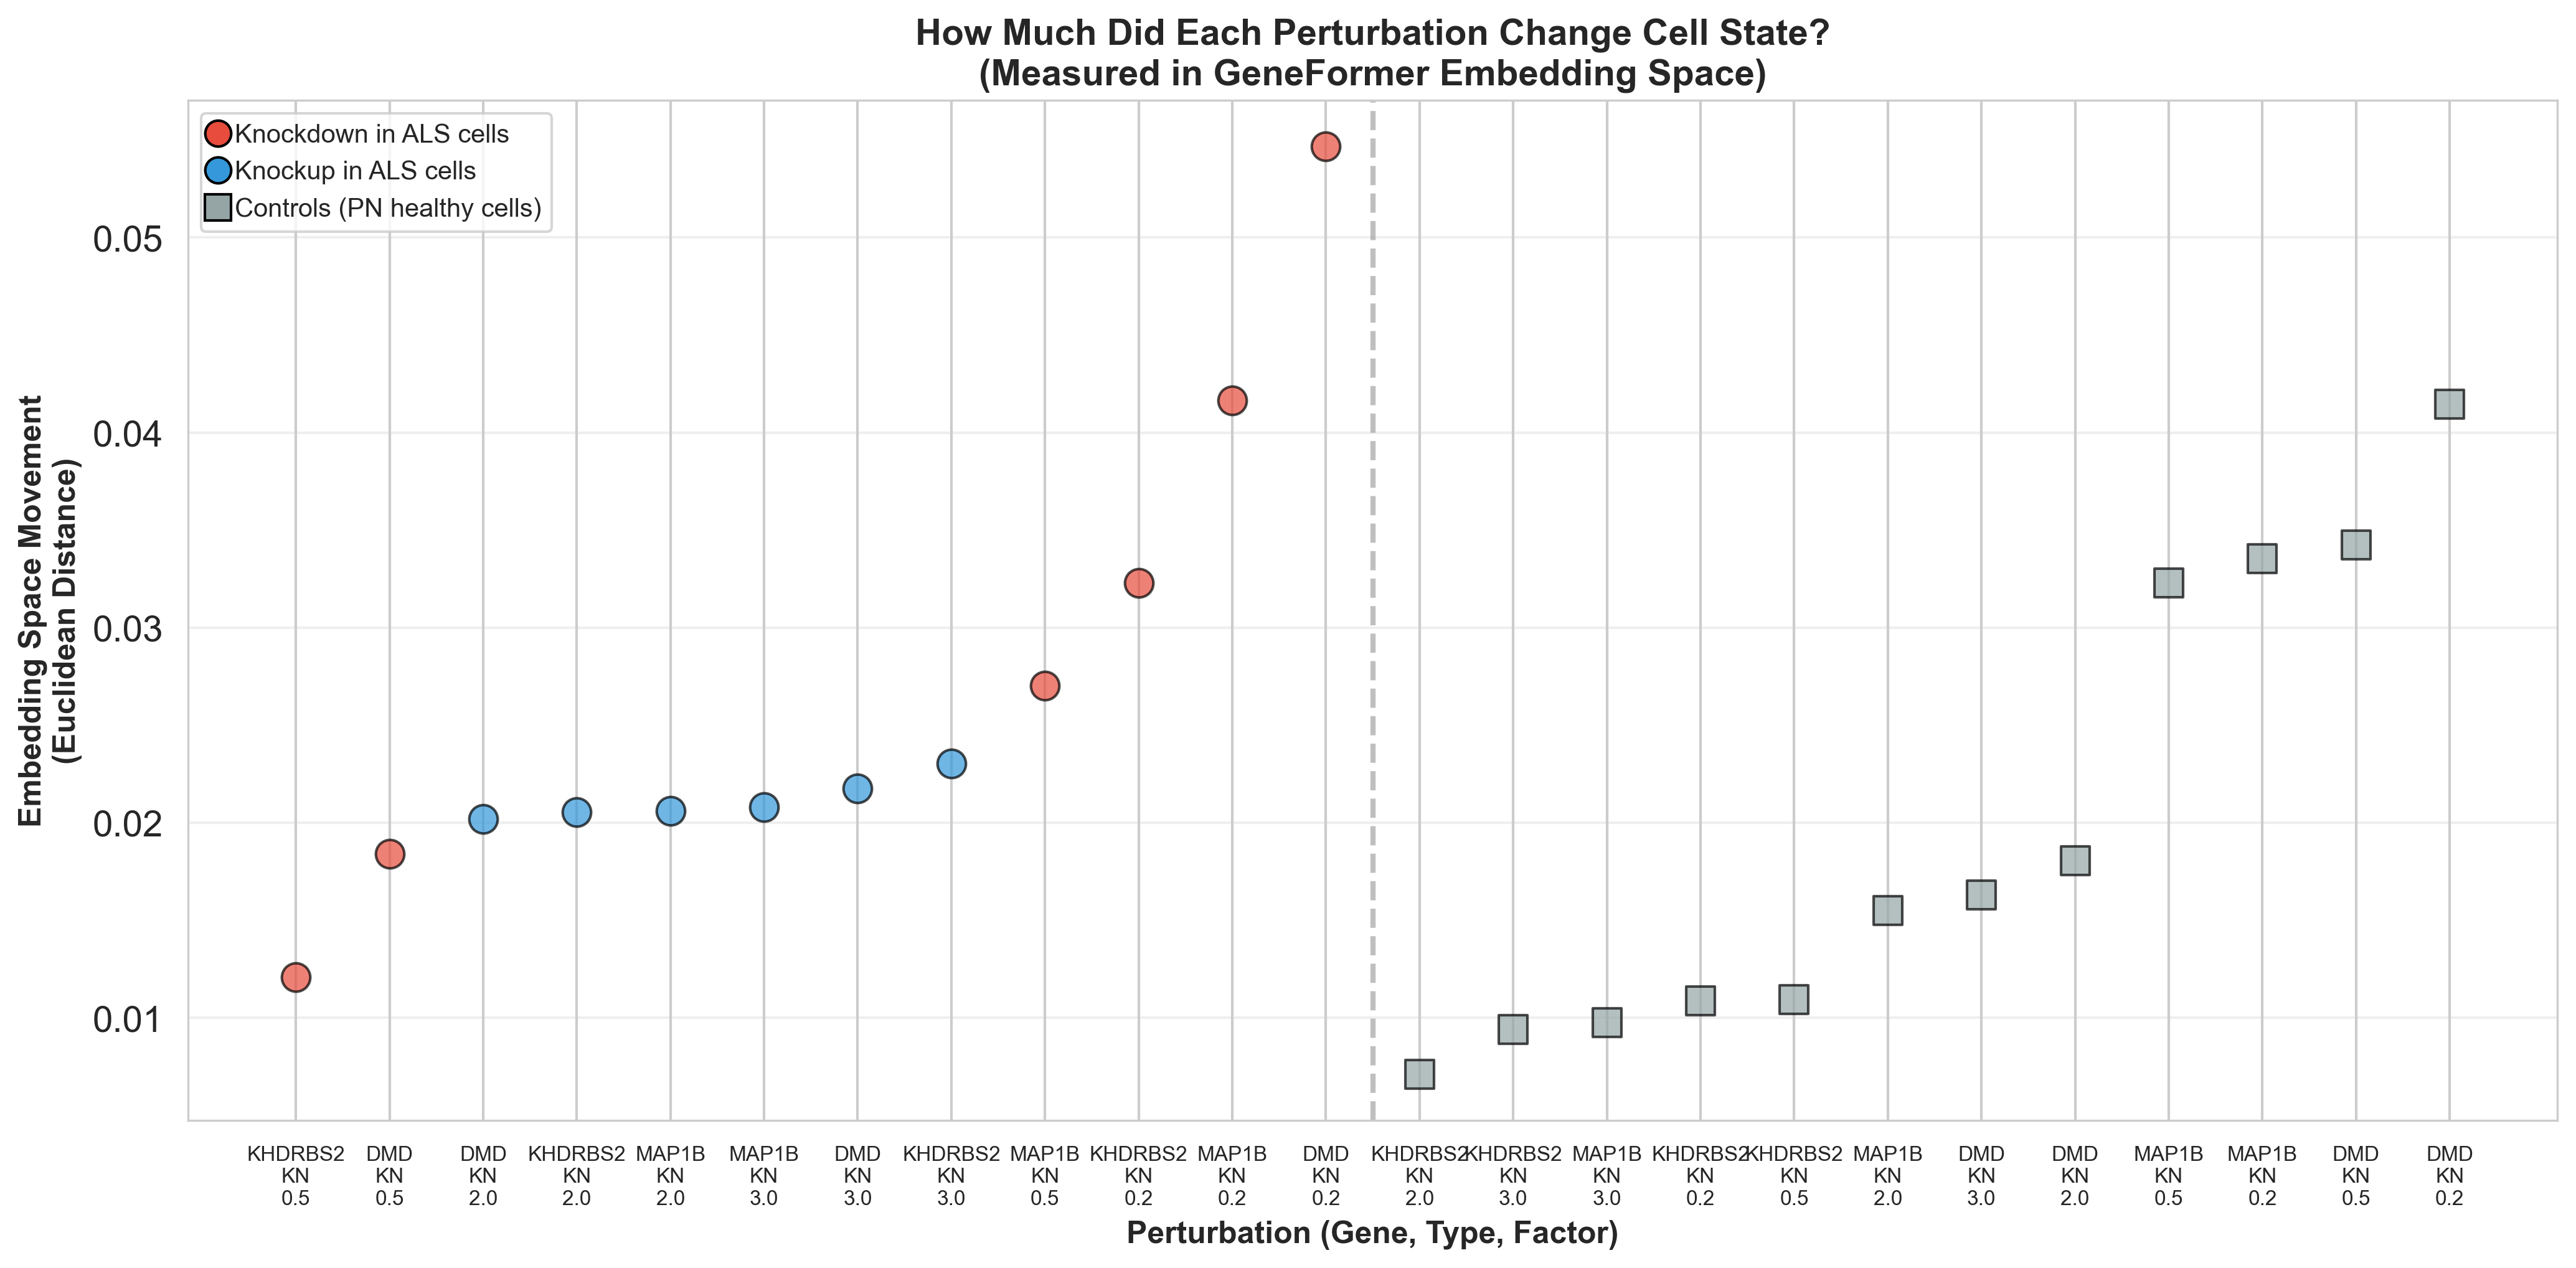


Top 5 perturbations by shift:
     perturbation_id   gene  centroid_shift
4     KD_DMD_0.2_ALS    DMD        0.054669
0   KD_MAP1B_0.2_ALS  MAP1B        0.041653
20     KD_DMD_0.2_PN    DMD        0.041446
21     KD_DMD_0.5_PN    DMD        0.034232
12   KD_MAP1B_0.2_PN  MAP1B        0.033535


In [22]:


print("\n" + "=" * 70)
print("QUICK SUMMARY")
print("=" * 70)

# Compute centroid shifts for all perturbations
print("\nComputing centroid shifts...")

baseline_centroid = baseline_embeddings.mean(axis=0)
shifts = []

for pert_id, pert_emb in perturbation_embeddings.items():
    pert_centroid = pert_emb.mean(axis=0)
    shift = np.linalg.norm(pert_centroid - baseline_centroid)
    shifts.append({'perturbation_id': pert_id, 'centroid_shift': shift})

shifts_df = pd.DataFrame(shifts)
shifts_df = metadata_df.merge(shifts_df, on='perturbation_id')

# Save quick summary
summary_path = TABLES_DIR / "quick_embedding_summary.csv"
shifts_df.to_csv(summary_path, index=False)
print(f"Quick summary saved: {summary_path}")

# Visualization - ENHANCED
fig, ax = plt.subplots(figsize=(14, 7))

# Group by condition for better organization
als_data = shifts_df[shifts_df['condition'] == 'ALS'].sort_values('centroid_shift')
pn_data = shifts_df[shifts_df['condition'] == 'PN'].sort_values('centroid_shift')

x_pos = 0
tick_positions = []
tick_labels = []

# Plot ALS perturbations
for _, row in als_data.iterrows():
    color = '#e74c3c' if row['type'] == 'knock_down' else '#3498db'
    marker = 'o'
    ax.scatter(x_pos, row['centroid_shift'], c=color, marker=marker, 
              s=120, alpha=0.7, edgecolors='black', linewidth=1)
    tick_positions.append(x_pos)
    tick_labels.append(f"{row['gene']}\n{row['type'][:2].upper()}\n{row['factor']}")
    x_pos += 1

# Add separator
ax.axvline(x_pos - 0.5, color='gray', linestyle='--', alpha=0.5, linewidth=2)

# Plot PN controls
for _, row in pn_data.iterrows():
    color = '#95a5a6'
    marker = 's'
    ax.scatter(x_pos, row['centroid_shift'], c=color, marker=marker, 
              s=120, alpha=0.7, edgecolors='black', linewidth=1)
    tick_positions.append(x_pos)
    tick_labels.append(f"{row['gene']}\n{row['type'][:2].upper()}\n{row['factor']}")
    x_pos += 1

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=8)
ax.set_xlabel('Perturbation (Gene, Type, Factor)', fontsize=12, fontweight='bold')
ax.set_ylabel('Embedding Space Movement\n(Euclidean Distance)', fontsize=12, fontweight='bold')
ax.set_title('How Much Did Each Perturbation Change Cell State?\n(Measured in GeneFormer Embedding Space)', 
            fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Better legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
           markersize=10, label='Knockdown in ALS cells', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db',
           markersize=10, label='Knockup in ALS cells', markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#95a5a6',
           markersize=10, label='Controls (PN healthy cells)', markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.tight_layout()
save_path = FIGURES_DIR / 'embedding_shifts_overview.png'
plt.savefig(save_path, dpi=config['visualization']['figure_dpi'], bbox_inches='tight')
plt.show()

print(f"\nTop 5 perturbations by shift:")
print(shifts_df.nlargest(5, 'centroid_shift')[['perturbation_id', 'gene', 'centroid_shift']])


# ## 12. Summary Report

In [20]:


print("\n" + "=" * 70)
print("TASK 2 COMPLETE")
print("=" * 70)

print(f"\nSummary:")
print(f"  ALS genes targeted: {len(target_genes)}")
print(f"  Perturbations created: {len(metadata_df)}")
print(f"    - ALS cells: {(metadata_df['condition'] == 'ALS').sum()}")
print(f"    - PN cells: {(metadata_df['condition'] == 'PN').sum()}")
print(f"  GeneFormer embeddings: {len(embeddings_dict)} sets")
print(f"  Mean centroid shift: {shifts_df['centroid_shift'].mean():.3f}")
print(f"  Disease distance (ALS ↔ PN): {baseline_disease_distance:.3f}")

print(f"\nOutputs:")
print(f"  {TASK2_DIR}/")
print(f"    tables/")
print(f"      - perturbation_metadata.csv")
print(f"      - quick_embedding_summary.csv")
print(f"    figures/")
print(f"      - embedding_shifts_overview.png")

print(f"\n  {CACHE_DIR}/")
print(f"    - task2_baseline_embeddings.npy")
print(f"    - task2_als_baseline_embeddings.npy")
print(f"    - task2_pn_baseline_embeddings.npy")
print(f"    - task2_reference_centroids.npz")
print(f"    - task2_*_embeddings.npy ({len(metadata_df)} files)")
print(f"    - task2_all_embeddings.h5")

print("\nKey Achievements:")
print("  Workflow applied to ALS gene set")
print("  Disease-specific perturbations created")
print("  Condition-specific baselines generated")
print("  Reference centroids computed for rescue analysis")
print("  GeneFormer V2 embeddings generated")
print("  All data cached for Task 3")

print("\nNext: Run Task 3 to interpret embedding space")
print("  - Disease rescue analysis (ALS → PN)")
print("  - Statistical significance testing")
print("  - Biological interpretation")


TASK 2 COMPLETE

Summary:
  ALS genes targeted: 3
  Perturbations created: 24
    - ALS cells: 12
    - PN cells: 12
  GeneFormer embeddings: 27 sets
  Mean centroid shift: 0.023
  Disease distance (ALS ↔ PN): 0.102

Outputs:
  /Users/lubainakothari/Desktop/perturbation_newstructure/results/task2/
    tables/
      - perturbation_metadata.csv
      - quick_embedding_summary.csv
    figures/
      - embedding_shifts_overview.png

  /Users/lubainakothari/Desktop/perturbation_newstructure/cache/
    - task2_baseline_embeddings.npy
    - task2_als_baseline_embeddings.npy
    - task2_pn_baseline_embeddings.npy
    - task2_reference_centroids.npz
    - task2_*_embeddings.npy (24 files)
    - task2_all_embeddings.h5

Key Achievements:
  Workflow applied to ALS gene set
  Disease-specific perturbations created
  Condition-specific baselines generated
  Reference centroids computed for rescue analysis
  GeneFormer V2 embeddings generated
  All data cached for Task 3

Next: Run Task 3 to interp

In [21]:


# Save comprehensive report
report_path = TABLES_DIR / 'task2_report.txt'
with open(report_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("TASK 2: ALS PERTURBATIONS + GENEFORMER EMBEDDINGS\n")
    f.write("=" * 70 + "\n\n")
    
    f.write("Objective: Apply workflow to ALS genes and generate embeddings\n\n")
    
    f.write(f"Dataset:\n")
    f.write(f"  Total cells: {adata.n_obs:,}\n")
    f.write(f"  ALS cells: {als_mask.sum():,}\n")
    f.write(f"  PN cells: {pn_mask.sum():,}\n\n")
    
    f.write(f"ALS Genes:\n")
    f.write(f"  Targeted: {len(target_genes)}\n")
    f.write(f"  List: {', '.join(target_genes)}\n\n")
    
    f.write(f"Perturbations:\n")
    f.write(f"  Total: {len(metadata_df)}\n")
    f.write(f"  Knock-downs: {(metadata_df['type'] == 'knock_down').sum()}\n")
    f.write(f"  Knock-ups: {(metadata_df['type'] == 'knock_up').sum()}\n")
    f.write(f"  ALS-targeted: {(metadata_df['condition'] == 'ALS').sum()}\n")
    f.write(f"  PN-targeted: {(metadata_df['condition'] == 'PN').sum()}\n\n")
    
    f.write(f"GeneFormer V2:\n")
    f.write(f"  Model: {config['geneformer']['model_name']}\n")
    f.write(f"  Embedding dimension: {baseline_embeddings.shape[1]}\n")
    f.write(f"  Total embedding sets: {len(embeddings_dict)}\n\n")
    
    f.write(f"Reference States:\n")
    f.write(f"  ALS baseline: {als_baseline_embeddings.shape}\n")
    f.write(f"  PN baseline: {pn_baseline_embeddings.shape}\n")
    f.write(f"  Disease distance (ALS ↔ PN): {baseline_disease_distance:.3f}\n\n")
    
    f.write(f"Embedding Shifts (Quick Summary):\n")
    f.write(f"  Mean: {shifts_df['centroid_shift'].mean():.3f}\n")
    f.write(f"  Max: {shifts_df['centroid_shift'].max():.3f}\n")
    f.write(f"  Min: {shifts_df['centroid_shift'].min():.3f}\n\n")
    
    f.write("Top 5 Perturbations by Centroid Shift:\n")
    for i, (_, row) in enumerate(shifts_df.nlargest(5, 'centroid_shift').iterrows(), 1):
        f.write(f"  {i}. {row['perturbation_id']}: {row['centroid_shift']:.3f}\n")
    
    f.write("\nStatus: Ready for Task 3 interpretation\n")

print(f"\nReport saved: {report_path}")


Report saved: /Users/lubainakothari/Desktop/perturbation_newstructure/results/task2/tables/task2_report.txt
